# Event detection with Recurrent Neural Networks - Part 2

In this fifth lab of the **ErSE 222 - Machine Learning in Geoscience** course, we will use different types of Recurrent Neural Network Deep to detect events in noisy seismic recordings. 

This is the second part of our lab and extends previous network architecture to include the *self-attention* layer that was first introduced in *Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. arXiv:1706.03762.* that introduced the famous Transformer architecture.

Here we will be using the implementation of self-attention in the [self-attention-cv](https://github.com/The-AI-Summer/self-attention-cv) library. However, since we want to look at the attention weights we need to make some small modifications to the original code base as shown below.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import io
import os
import glob
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from einops import rearrange
from tqdm.notebook import tqdm_notebook as tqdm
from torch.utils.data import TensorDataset, DataLoader 
from sklearn.metrics import accuracy_score, classification_report
from self_attention_cv import MultiHeadSelfAttention

import datacreation as dc

In [2]:
def set_seed(seed):
    """Set all random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

In [3]:
def compute_mhsa(q, k, v, scale_factor=1, mask=None):
    # resulted shape will be: [batch, heads, tokens, tokens]
    scaled_dot_prod = torch.einsum('... i d , ... j d -> ... i j', q, k) * scale_factor

    if mask is not None:
        assert mask.shape == scaled_dot_prod.shape[2:]
        scaled_dot_prod = scaled_dot_prod.masked_fill(mask, -np.inf)

    attention = torch.softmax(scaled_dot_prod, dim=-1)
    # calc result per head
    return torch.einsum('... i j , ... j d -> ... i d', attention, v), attention


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=None):
        """
        Implementation of multi-head attention layer of the original transformer model.
        einsum and einops.rearrange is used whenever possible
        Args:
            dim: token's dimension, i.e. word embedding vector size
            heads: the number of distinct representations to learn
            dim_head: the dim of the head. In general dim_head<dim.
            However, it may not necessary be (dim/heads)
        """
        super().__init__()
        self.dim_head = (int(dim / heads)) if dim_head is None else dim_head
        _dim = self.dim_head * heads
        self.heads = heads
        self.to_qvk = nn.Linear(dim, _dim * 3, bias=False)
        self.W_0 = nn.Linear(_dim, dim, bias=False)
        self.scale_factor = self.dim_head ** -0.5

    def forward(self, x, mask=None):
        assert x.dim() == 3
        qkv = self.to_qvk(x)  # [batch, tokens, dim*3*heads ]

        # decomposition to q,v,k and cast to tuple
        # the resulted shape before casting to tuple will be: [3, batch, heads, tokens, dim_head]
        q, k, v = tuple(rearrange(qkv, 'b t (d k h ) -> k b h t d ', k=3, h=self.heads))

        out, attention = compute_mhsa(q, k, v, mask=mask, scale_factor=self.scale_factor)

        # re-compose: merge heads with dim_head
        out = rearrange(out, "b h t d -> b t (h d)")
        # Apply final linear transformation layer
        return self.W_0(out), attention

Let's begin by checking we have access to a GPU and tell Torch we would like to use it:

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
set_seed(40)

True

Finally we set a flag that chooses whether we want to train our networks or load pre-trained ones. 

In this lab we will first train our networks and later simply load them if we want to just do some predictions on new data.

In [6]:
loadmodel = True
modelsdir = './'

## Data creation

To begin with we need to create a large variety of training data. Each training pair will be composed of a seismic trace and a trigger trace, where the latter is equal 1 in correspondance of the seismic event and 0 elsewhere.

The seismic trace is created as follows:

$$
s(t) = a * w(t;f) * r(t;t_0) + n(t, SNR)
$$

where the central frequency of the wavelet $f$, the time of the event $t_0$, and $SNR$ are randomly chosen for each trace. Moreover, some of the traces contain only noise, this is driven by the $a$ parameter. 

In [7]:
# Input paramters
nt = 500 # number of time samples
dt = 0.002 # time sampling
#SNR = [50., 100., -1., 70.] # signal to noise ratio paramters (min, max, skewness, mean)
SNR = [5., 10., -1., 4.] # signal to noise ratio paramters (min, max, skewness, mean)
#SNR = [2., 5., -1., 3.] # signal to noise ratio paramters (min, max, skewness, mean)
noise_freq = [2, 40] # min and max frequency of noise
wavelet_freq = [20, 30] # min and max frequency of wavelet

ntraining = 500 # number of training samples
ntest = 50 # number of test samples

In [8]:
# Create data
traindata = [dc.create_data(nt=nt, dt=dt,
                            snrparams=SNR, 
                            freqwav=wavelet_freq, 
                            freqbp=noise_freq, 
                            signal=True) 
             for i in tqdm(range(ntraining))]

testdata = [dc.create_data(nt=nt, dt=dt,
                           snrparams=SNR, 
                           freqwav=wavelet_freq, 
                           freqbp=noise_freq, 
                           signal=True) 
            for i in tqdm(range(ntest))]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
train_data_X = np.zeros([ntraining, nt, 1])
train_data_y = np.zeros([ntraining, nt])

for i, d in enumerate(traindata):  
    train_data_X[i, :, 0] = d['synthetic']
    train_data_y[i, :] = d['labels']

In [10]:
test_data_X = np.zeros([ntest, nt, 1])
test_data_y = np.zeros([ntest, nt])

for i, d in enumerate(testdata):  
    test_data_X[i, :, 0] = d['synthetic']
    test_data_y[i, :] = d['labels']

In [11]:
# percentage of 0 labels over 1 labels
scaling = np.round(np.mean([(nt-np.sum(traindata[i]['labels']))/np.sum(traindata[i]['labels']) for i in range(ntraining)]))
scaling

11.0

Let's take a look at the data we are going to work with

In [12]:
def plotting(X1, y1, X2, y2, title1, title2, y1prob=None, y2prob=None, dt=0.002, nplot=3):
    fig, axs = plt.subplots(nplot, 2, figsize=[15, nplot*2])
    nt = len(X1[0])
    for t in range(nplot):
        axs[t, 0].set_title(title1)
        axs[t, 0].plot(np.arange(nt)*dt, X1[t].squeeze(),'k')
        axs[t, 0].fill_between(np.arange(nt)*dt,
                               y1=1*y1[t].squeeze(), 
                               y2=-1*y1[t].squeeze(),
                               linewidth=0.0,
                               color='#E6DF44')
        if y1prob is not None:
            axs[t, 0].plot(np.arange(nt)*dt, y1prob[t].squeeze(), '#E6DF44', lw=2)

        axs[t, 1].set_title(title2)
        axs[t, 1].plot(np.arange(nt)*dt, X2[t].squeeze(),'k')
        axs[t, 1].fill_between(np.arange(nt)*dt,
                               y1=1*y2[t].squeeze(), 
                               y2=-1*y2[t].squeeze(),
                               linewidth=0.0,
                               color='#A2C523')
        if y2prob is not None:
            axs[t, 1].plot(np.arange(nt)*dt, y2prob[t].squeeze(), '#A2C523', lw=2)

    for ax in axs.ravel():
        ax.set_xlim([0,dt*nt])
        ax.set_ylim([-1,1])

    fig.tight_layout()

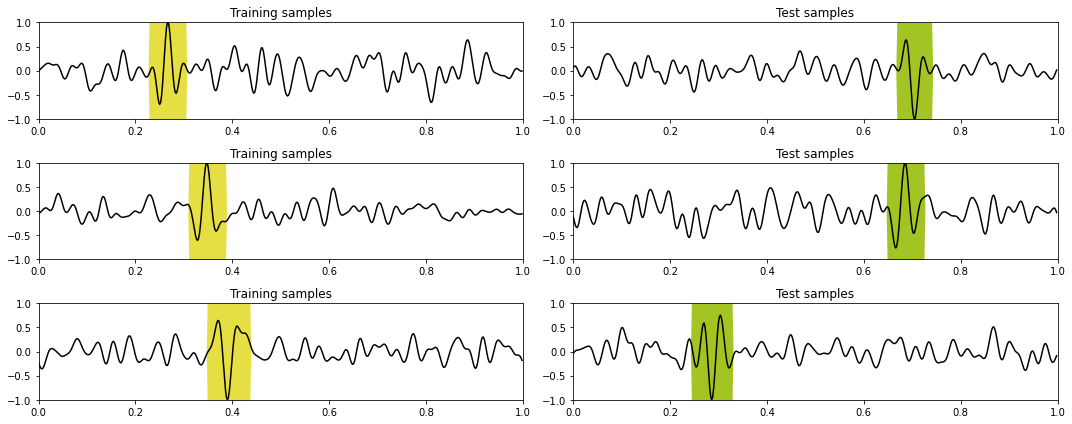

In [13]:
nplot = 3
plotting(train_data_X, train_data_y, test_data_X, test_data_y, 
         'Training samples', 'Test samples', dt=dt, nplot=3)

## Training

Let's now prepare some training routines similar to those we have already seen in the other labs.

In [14]:
def train(model, criterion, optimizer, data_loader, device='cpu'):
    model.train()
    accuracy = 0
    loss = 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)            
        optimizer.zero_grad()
        yprob = model(X)[0]
        ls = criterion(yprob.view(-1), y.view(-1))
        ls.backward()
        optimizer.step()
        y_pred = np.where(yprob.detach().cpu().numpy() > 0.5, 1, 0).astype(np.float32)
        loss += ls.item()
        accuracy += accuracy_score(y.cpu().numpy().ravel(), y_pred.ravel())
    loss /= len(data_loader)
    accuracy /= len(data_loader)
    return loss, accuracy

In [15]:
def evaluate(model, criterion, data_loader, device='cpu'):
    model.eval()
    accuracy = 0
    loss = 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)            
        with torch.no_grad(): # use no_grad to avoid making the computational graph...
            yprob = model(X)[0]
            ls = criterion(yprob.view(-1), y.view(-1))
        y_pred = np.where(yprob.cpu().numpy() > 0.5, 1, 0).astype(np.float32)
        loss += ls.item()
        accuracy += accuracy_score(y.cpu().numpy().ravel(), y_pred.ravel())
    loss /= len(data_loader)
    accuracy /= len(data_loader)
    return loss, accuracy

In [16]:
def predict(model, X, y, label, device='cpu', dt=0.002, nplot=5, report=False):
    model.eval()
    X = X.to(device)

    with torch.no_grad(): # use no_grad to avoid making the computational graph...
        yprob = nn.Sigmoid()(model(X)[0])
    y_pred = np.where(yprob.cpu().numpy() > 0.5, 1, 0)
    
    if report:
        classification_report(y, y_pred)
    
    plotting(X.cpu().detach().numpy().squeeze(), 
             y, X.cpu().detach().numpy().squeeze(), 
             y_pred, y2prob=yprob.cpu().numpy(), 
             title1='True', title2=label, dt=dt, nplot=nplot)

In [17]:
def training(network, loss, optim, nepochs, train_loader, test_loader, 
             device='cpu', modeldir=None, modelname=''):
    iepoch_best = 0
    train_loss_history = np.zeros(nepochs)
    valid_loss_history = np.zeros(nepochs)
    train_acc_history = np.zeros(nepochs)
    valid_acc_history = np.zeros(nepochs)
    for i in range(nepochs):
        train_loss, train_accuracy = train(network, loss, optim, 
                                           train_loader, device=device)
        valid_loss, valid_accuracy = evaluate(network, loss, 
                                              test_loader, device=device)
        train_loss_history[i] = train_loss
        valid_loss_history[i] = valid_loss
        train_acc_history[i] = train_accuracy
        valid_acc_history[i] = valid_accuracy
        if modeldir is not None:
            if i == 0 or valid_accuracy > np.max(valid_acc_history[:i]):        
                iepoch_best = i
                torch.save(network.state_dict(), os.path.join(modeldir, 'models', model+'.pt'))
        if i % 10 == 0:
            print(f'Epoch {i}, Training Loss {train_loss:.3f}, Training Accuracy {train_accuracy:.3f}, Test Loss {valid_loss:.3f}, Test Accuracy {valid_accuracy:.3f}')
    return train_loss_history, valid_loss_history, train_acc_history, valid_acc_history, iepoch_best

We are finally ready to prepare the training and test data

In [18]:
# Define Train Set
X_train = torch.from_numpy(train_data_X).float()
y_train = torch.from_numpy(train_data_y).float()

train_dataset = TensorDataset(X_train, y_train)

# Define Test Set
X_test = torch.from_numpy(test_data_X).float()
y_test = torch.from_numpy(test_data_y).float()

test_dataset = TensorDataset(X_test, y_test)

# Use Pytorch's functionality to load data in batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Double LSTM

First of all, let's see how we can modify the bidirectional LSTM network in our previous notebook to include a stack of 2 LSTM layers (here the first is bidirectional, the second is unidirectional)

In [19]:
class DoubleLSTMNetwork(nn.Module):
    def __init__(self, I, He, Hd, O):
        super(DoubleLSTMNetwork, self).__init__()
        self.encoder = nn.LSTM(I, He, 1, batch_first=True, bidirectional=True)
        self.decoder = nn.LSTM(2*He, Hd, batch_first=True)
        self.dense = nn.Linear(Hd, O, bias=False)
        
    def forward(self, x):
        # Encoder
        z, _ = self.encoder(x)
        # Attention+Decoder
        z2, _ = self.decoder(z)
        # Dense
        out = self.dense(z2)
        return out.squeeze(), None

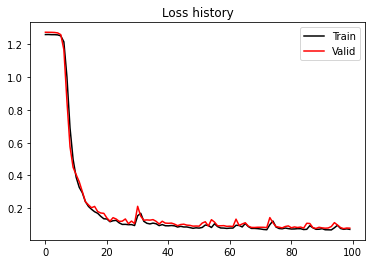

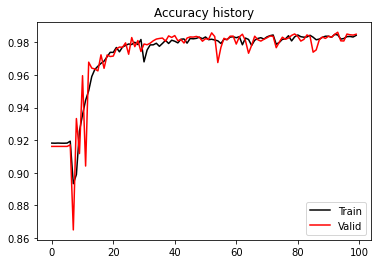

In [20]:
model = 'doublelstm_strongweightedbce'
nepochs = 100

if not loadmodel:
    # Train
    network = DoubleLSTMNetwork(1, 200, 100, 1)
    network.to(device)

    bce_loss_weight = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([scaling, ]).to(device))
    optim = torch.optim.Adam(network.parameters(), lr=1e-4)

    train_loss_history, valid_loss_history, train_acc_history, valid_acc_history, iepoch_best = \
        training(network, bce_loss_weight, optim, nepochs, train_loader, test_loader,
                 device=device, modeldir=modelsdir, modelname=model)
    print('Best epoch: %d' % iepoch_best)
    
    np.savez(os.path.join(modelsdir, 'models', model + '_trainhistory'), 
             train_loss_history=train_loss_history,
             valid_loss_history=valid_loss_history,
             train_acc_history=train_acc_history,
             valid_acc_history=valid_acc_history,
             iepoch_best=iepoch_best)
else:
    # Load best model
    network = DoubleLSTMNetwork(1, 200, 100, 1)
    network.load_state_dict(torch.load(os.path.join(modelsdir, 'models', model+'.pt')))
    network.to(device)
    
    fhist = np.load(os.path.join(modelsdir, 'models', model + '_trainhistory.npz'))
    train_loss_history = fhist['train_loss_history']
    valid_loss_history = fhist['valid_loss_history']
    train_acc_history = fhist['train_acc_history']
    valid_acc_history = fhist['valid_acc_history']

plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(valid_loss_history, 'r', label='Valid')
plt.title('Loss history')
plt.legend()

plt.figure()
plt.plot(train_acc_history, 'k', label='Train')
plt.plot(valid_acc_history, 'r', label='Valid')
plt.title('Accuracy history')
plt.legend()

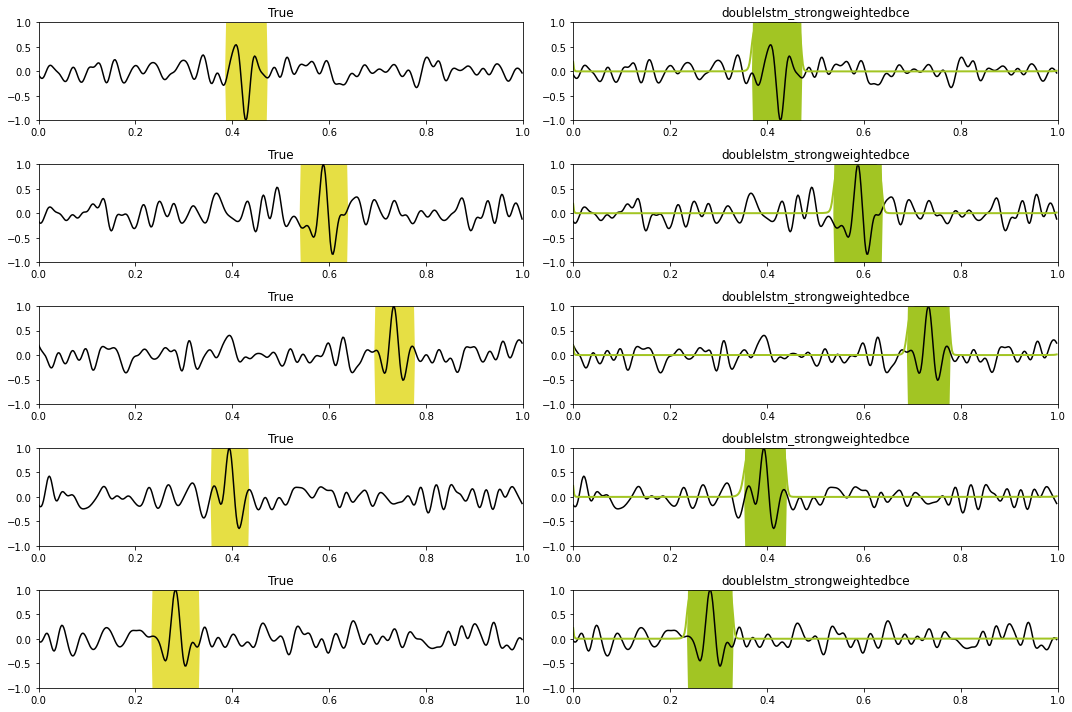

In [21]:
# Prediction train
X, y = next(iter(train_loader))
predict(network, X, y, model, device, dt=dt, nplot=5)

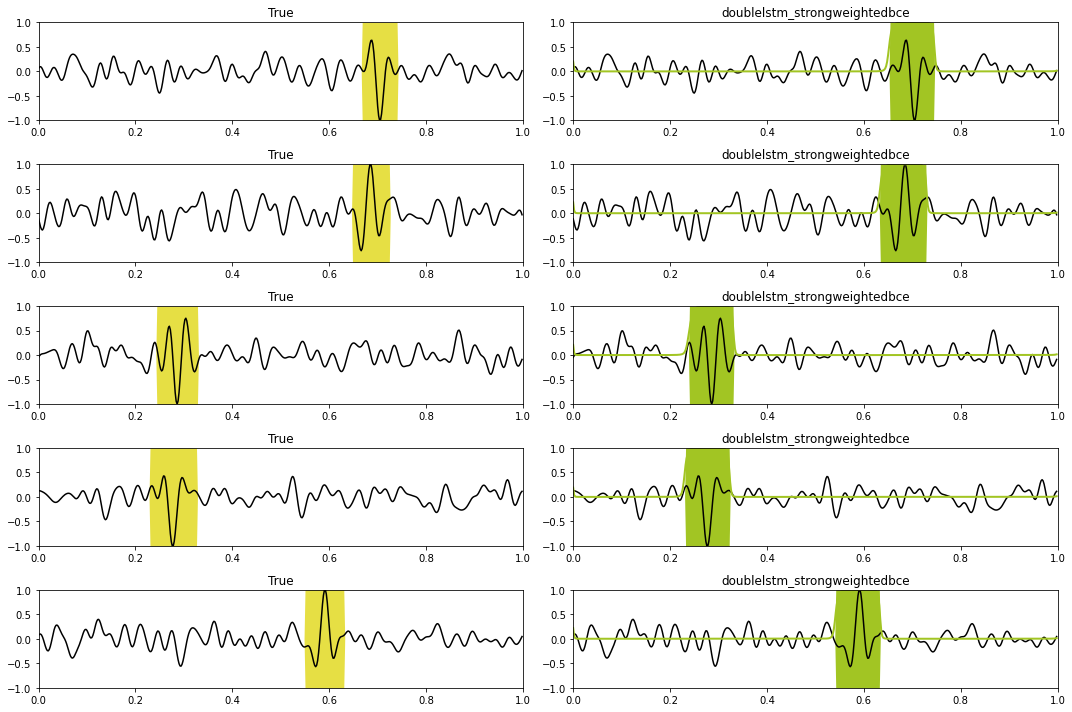

In [22]:
# Prediction test
X, y = next(iter(test_loader))
predict(network, X, y, model, device, dt=dt, nplot=5)

### BidirLSTM + Self-Attention

Now we add a self-attention layer between the two LSTM.

In [38]:
class SelfAttentionNetwork(nn.Module):
    def __init__(self, I, He, Hd, O):
        super(SelfAttentionNetwork, self).__init__()
        self.encoder = nn.LSTM(I, He, 1, batch_first=True, bidirectional=True)
        self.attention = MultiHeadSelfAttention(dim=2*He)
        self.decoder = nn.LSTM(2*He, Hd, batch_first=True)
        self.dense = nn.Linear(Hd, O, bias=False)
        
    def forward(self, x):
        # Encoder
        z, _ = self.encoder(x)
        # Attention+Decoder
        z1, attention = self.attention(z)
        z2, _ = self.decoder(z)
        # Dense
        out = self.dense(z2)
        return out.squeeze(), attention

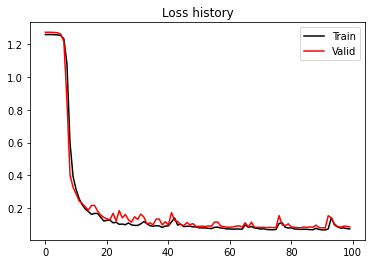

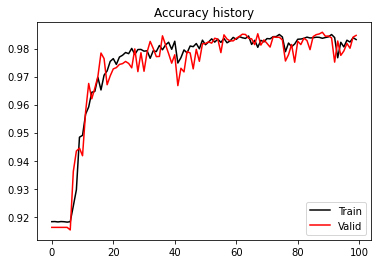

In [39]:
model = 'selfattention_strongweightedbce'
nepochs = 100

if not loadmodel:
    # Train
    network = SelfAttentionNetwork(1, 200, 100, 1)
    network.to(device)

    bce_loss_weight = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([scaling, ]).to(device))
    optim = torch.optim.Adam(network.parameters(), lr=1e-4)

    train_loss_history, valid_loss_history, train_acc_history, valid_acc_history, iepoch_best = \
        training(network, bce_loss_weight, optim, nepochs, train_loader, test_loader,
                 device=device, modeldir=modelsdir, modelname=model)
    print('Best epoch: %d' % iepoch_best)
    
    np.savez(os.path.join(modelsdir, 'models', model + '_trainhistory'), 
             train_loss_history=train_loss_history,
             valid_loss_history=valid_loss_history,
             train_acc_history=train_acc_history,
             valid_acc_history=valid_acc_history,
             iepoch_best=iepoch_best)
else:
    # Load best model
    network = SelfAttentionNetwork(1, 200, 100, 1)
    network.load_state_dict(torch.load(os.path.join(modelsdir, 'models', model+'.pt')))
    network.to(device)
    
    fhist = np.load(os.path.join(modelsdir, 'models', model + '_trainhistory.npz'))
    train_loss_history = fhist['train_loss_history']
    valid_loss_history = fhist['valid_loss_history']
    train_acc_history = fhist['train_acc_history']
    valid_acc_history = fhist['valid_acc_history']

plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(valid_loss_history, 'r', label='Valid')
plt.title('Loss history')
plt.legend()

plt.figure()
plt.plot(train_acc_history, 'k', label='Train')
plt.plot(valid_acc_history, 'r', label='Valid')
plt.title('Accuracy history')
plt.legend();

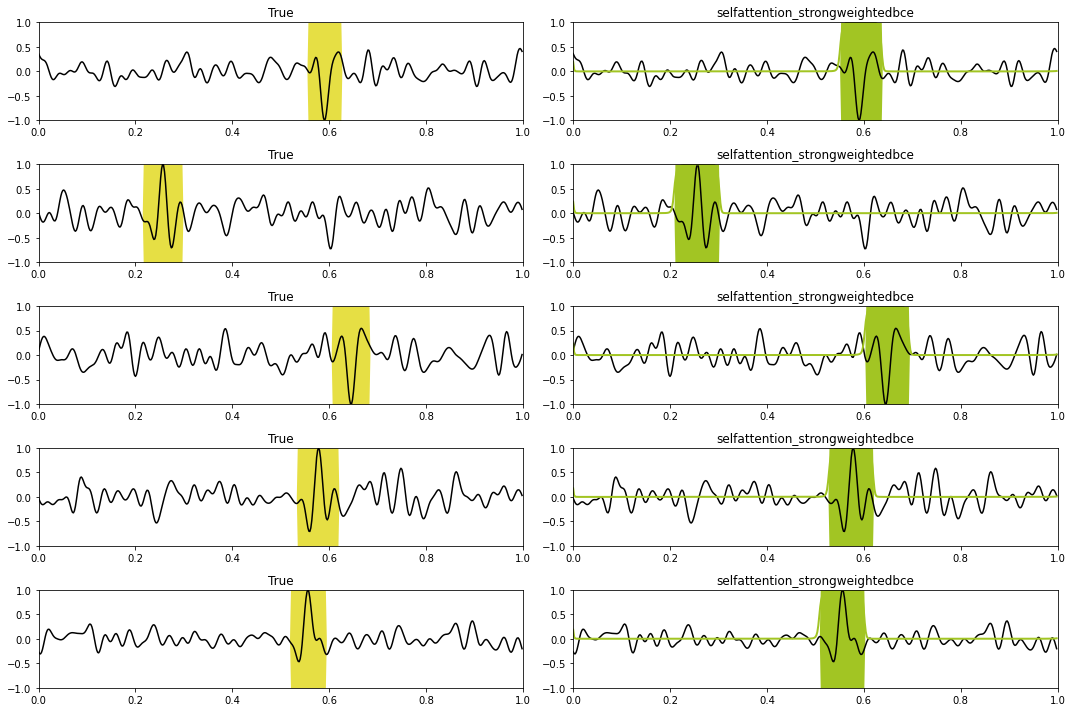

In [40]:
# Prediction train
X, y = next(iter(train_loader))
predict(network, X, y, model, device, dt=dt, nplot=5)

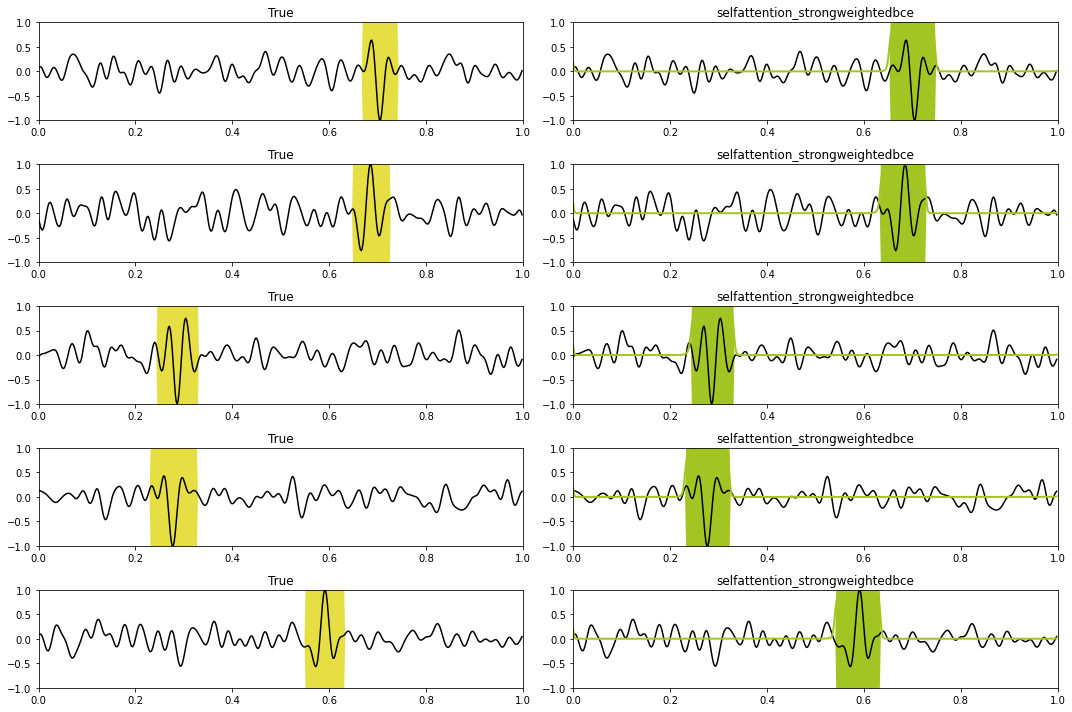

In [41]:
# Prediction test
X, y = next(iter(test_loader))
predict(network, X, y, model, device, dt=dt, nplot=5)

Let's now look at the attention weights for a single test sample

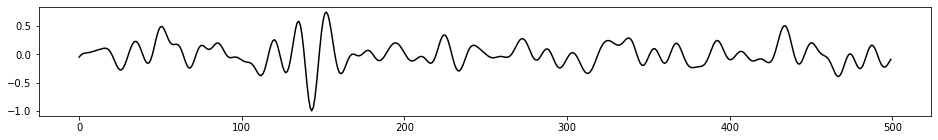

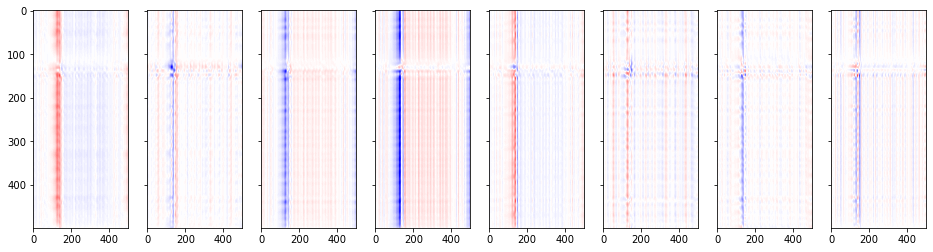

In [42]:
isample = 2
X, y = next(iter(test_loader))

network.eval()
X = X.to(device)
with torch.no_grad():
    _, attentionw = network(X[isample:isample+1])
    
plt.figure(figsize=(16, 2))
plt.plot(X[isample].squeeze(), 'k')

fig, axs = plt.subplots(1, 8, sharey=True, figsize=(16, 4))
for iatt in range(8):
    axs[iatt].imshow(attentionw.squeeze()[iatt].detach().cpu().numpy(), 
                     cmap='seismic',
                     vmin=0.0019, vmax=0.0021)
    axs[iatt].axis('tight')

### BidirLSTM + Self-Attention light

Finally we make a very similar architecture where we reduce the number of heads but use two bidirectional LSTMs.

In [43]:
class SelfAttentionLightNetwork(nn.Module):
    def __init__(self, I, He, Hd, O):
        super(SelfAttentionLightNetwork, self).__init__()
        self.encoder = nn.LSTM(I, He, 1, batch_first=True, bidirectional=True)
        self.attention = MultiHeadSelfAttention(dim=2*He, heads=2)
        self.decoder = nn.LSTM(2*He, Hd, batch_first=True, bidirectional=True)
        self.dense = nn.Linear(2*Hd, O, bias=False)
        
    def forward(self, x):
        # Encoder
        z, _ = self.encoder(x)
        # Attention+Decoder
        z1, attention = self.attention(z)
        z2, _ = self.decoder(z)
        # Dense
        out = self.dense(z2)
        return out.squeeze(), attention

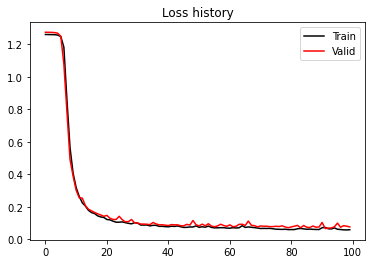

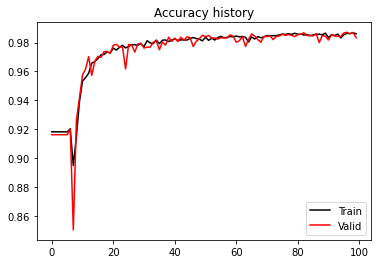

In [44]:
model = 'selfattentionlight_strongweightedbce'
nepochs = 100

if not loadmodel:
    # Train
    network = SelfAttentionLightNetwork(1, 200, 100, 1)
    network.to(device)

    bce_loss_weight = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([scaling, ]).to(device))
    optim = torch.optim.Adam(network.parameters(), lr=1e-4)

    train_loss_history, valid_loss_history, train_acc_history, valid_acc_history, iepoch_best = \
        training(network, bce_loss_weight, optim, nepochs, train_loader, test_loader,
                 device=device, modeldir=modelsdir, modelname=model)
    print('Best epoch: %d' % iepoch_best)
    
    np.savez(os.path.join(modelsdir, 'models', model + '_trainhistory'), 
             train_loss_history=train_loss_history,
             valid_loss_history=valid_loss_history,
             train_acc_history=train_acc_history,
             valid_acc_history=valid_acc_history,
             iepoch_best=iepoch_best)
else:
    # Load best model
    network = SelfAttentionLightNetwork(1, 200, 100, 1)
    network.load_state_dict(torch.load(os.path.join(modelsdir, 'models', model+'.pt')))
    network.to(device)
    
    fhist = np.load(os.path.join(modelsdir, 'models', model + '_trainhistory.npz'))
    train_loss_history = fhist['train_loss_history']
    valid_loss_history = fhist['valid_loss_history']
    train_acc_history = fhist['train_acc_history']
    valid_acc_history = fhist['valid_acc_history']

plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(valid_loss_history, 'r', label='Valid')
plt.title('Loss history')
plt.legend()

plt.figure()
plt.plot(train_acc_history, 'k', label='Train')
plt.plot(valid_acc_history, 'r', label='Valid')
plt.title('Accuracy history')
plt.legend();

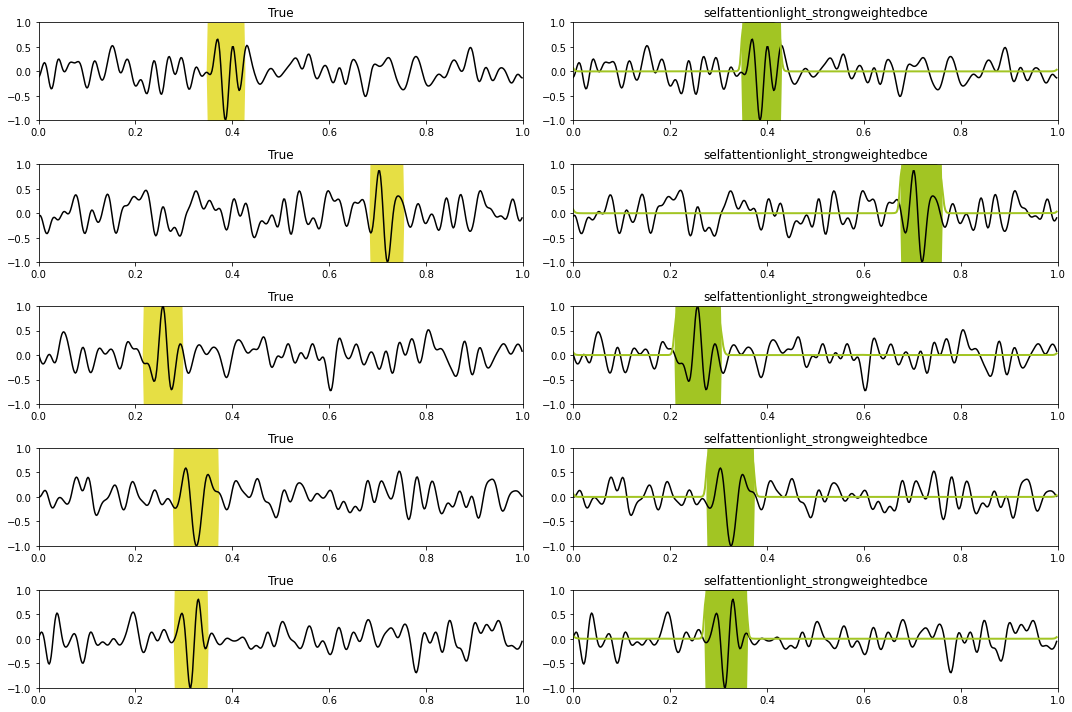

In [45]:
# Prediction train
X, y = next(iter(train_loader))
predict(network, X, y, model, device, dt=dt, nplot=5)

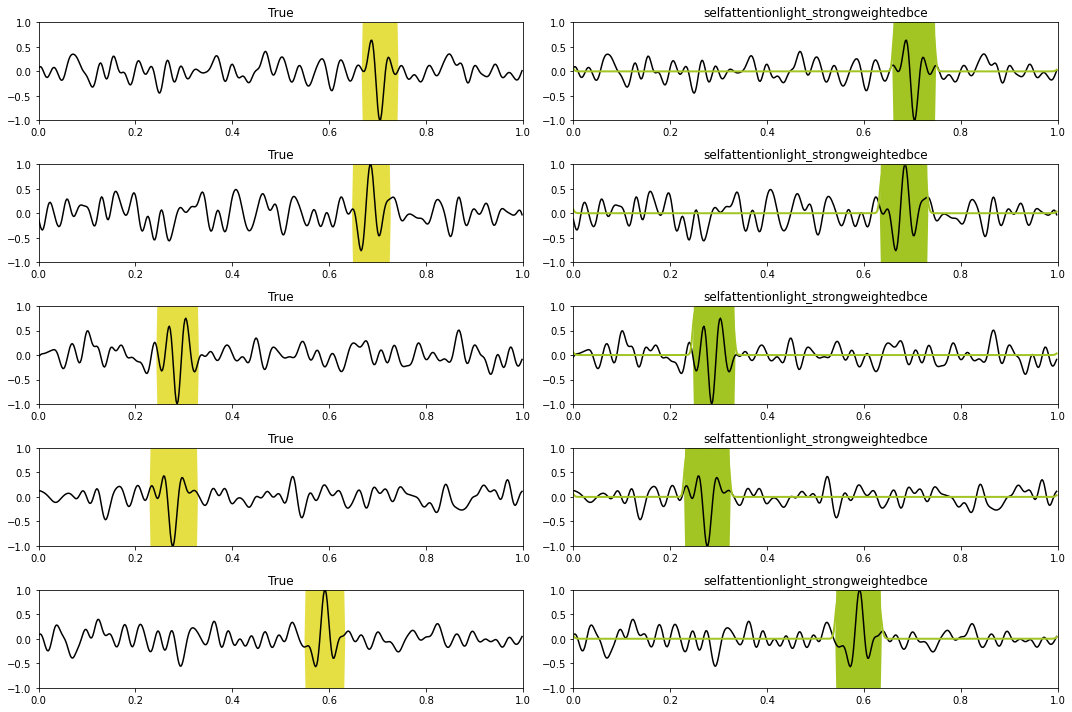

In [46]:
# Prediction test
X, y = next(iter(test_loader))
predict(network, X, y, model, device, dt=dt, nplot=5)

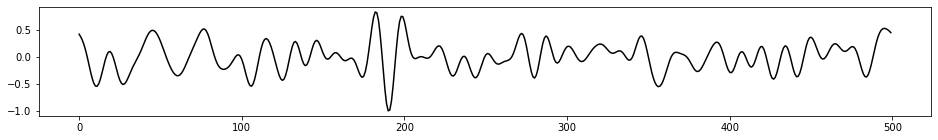

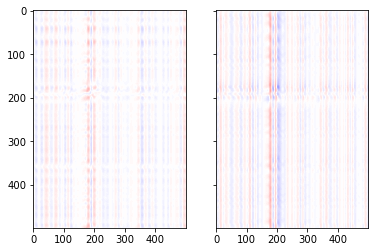

In [51]:
isample = 5
X, y = next(iter(test_loader))

network.eval()
X = X.to(device)
with torch.no_grad():
    _, attentionw = network(X[isample:isample+1])
    
plt.figure(figsize=(16, 2))
plt.plot(X[isample].squeeze(), 'k')

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6, 4))
for iatt in range(2):
    axs[iatt].imshow(attentionw.squeeze()[iatt].detach().cpu().numpy(), 
                     cmap='seismic',
                     vmin=0.0019, vmax=0.0021)
    axs[iatt].axis('tight')